In [1]:
from skimage import io, measure, color
import numpy as np
io.use_plugin('matplotlib')
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from math import sin, cos, ceil, floor

In [2]:
def binarize(img):
    return cv2.threshold((color.rgb2gray(img) * 255).astype(np.uint8),20,255,cv2.THRESH_BINARY)[1]

In [11]:
real_imgs = [io.imread('Klad00.jpg'), io.imread('Klad01.jpg'), io.imread('Klad02.jpg')]

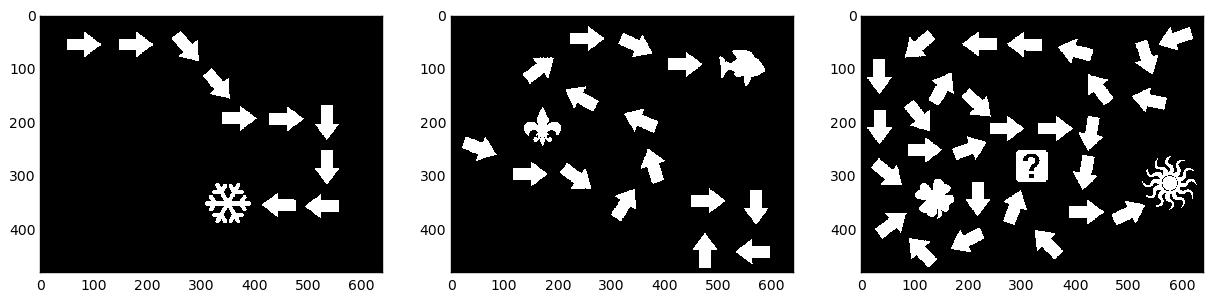

In [3]:
imgs = []
plt.figure(figsize=(15, 20))
plt.subplot(1, 3, 1)
imgs.append(binarize(io.imread('Klad00.jpg')))
io.imshow(imgs[0])
plt.subplot(1, 3, 2)
imgs.append(binarize(io.imread('Klad01.jpg')))
io.imshow(imgs[1])
plt.subplot(1, 3, 3)
imgs.append(binarize(io.imread('Klad02.jpg')))
io.imshow(imgs[2])

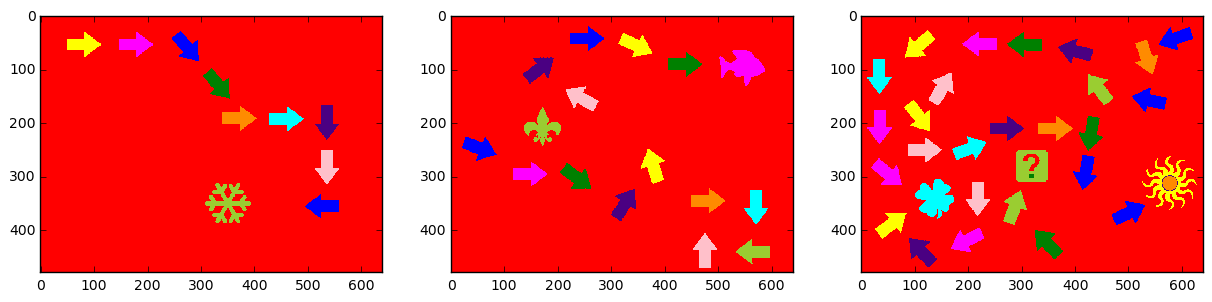

In [4]:
all_labels = []
plt.figure(figsize=(15, 20))
plt.subplot(1, 3, 1)
all_labels.append(measure.label(imgs[0]))
io.imshow(color.label2rgb(all_labels[0]))
plt.subplot(1, 3, 2)
all_labels.append(measure.label(imgs[1]))
io.imshow(color.label2rgb(all_labels[1]))
plt.subplot(1, 3, 3)
all_labels.append(measure.label(imgs[2]))
io.imshow(color.label2rgb(all_labels[2]))

### Найдем все стрелки

In [13]:
def get_arrows(img_labeled):
    arrows = []
    img_only_arrows = np.zeros((img_labeled.shape))
    labels = np.unique(img_labeled)
    for label in labels:
        if 1400 <= np.sum(img_labeled == label) <= 2000:
            arrows.append(label)
    for i in xrange(img_labeled.shape[0]):
        for j in xrange(img_labeled.shape[1]):
            if img_labeled[i][j] in arrows:
                img_only_arrows[i][j] = img_labeled[i][j]
    #print len(arrows)
    return arrows, img_only_arrows

10
15
28


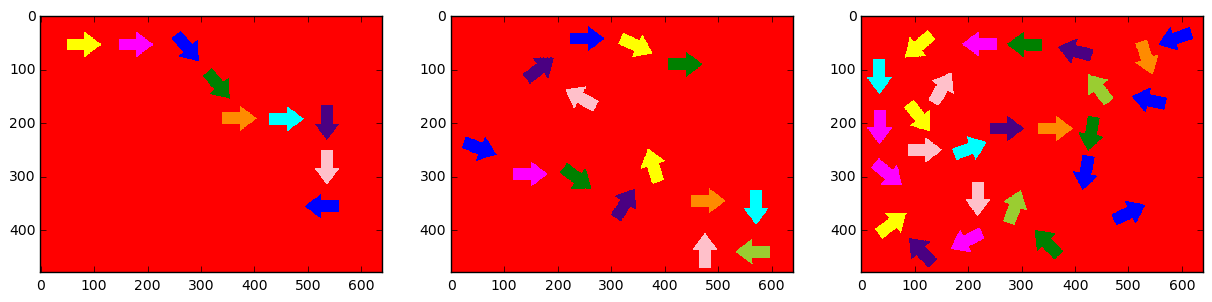

In [6]:
plt.figure(figsize=(15, 20))
plt.subplot(1, 3, 1)
io.imshow(color.label2rgb(get_arrows(all_labels[0])[1]))
plt.subplot(1, 3, 2)
io.imshow(color.label2rgb(get_arrows(all_labels[1])[1]))
plt.subplot(1, 3, 3)
io.imshow(color.label2rgb(get_arrows(all_labels[2])[1]))

### Найдем первую стрелку

In [20]:
def get_start_arrow(img, img_labeled):
    arrows = get_arrows(img_labeled)[0]
    img_first_arrow = np.zeros((img_labeled.shape))
    for arrow in arrows:
        # посчитаем таким образом цвет стрелки
        if np.mean(img[img_labeled == arrow]) < 90:
            for i in xrange(img_labeled.shape[0]):
                for j in xrange(img_labeled.shape[1]):
                    if img_labeled[i][j] == arrow:
                        img_first_arrow[i][j] = img_labeled[i][j]
            return arrow, img_first_arrow

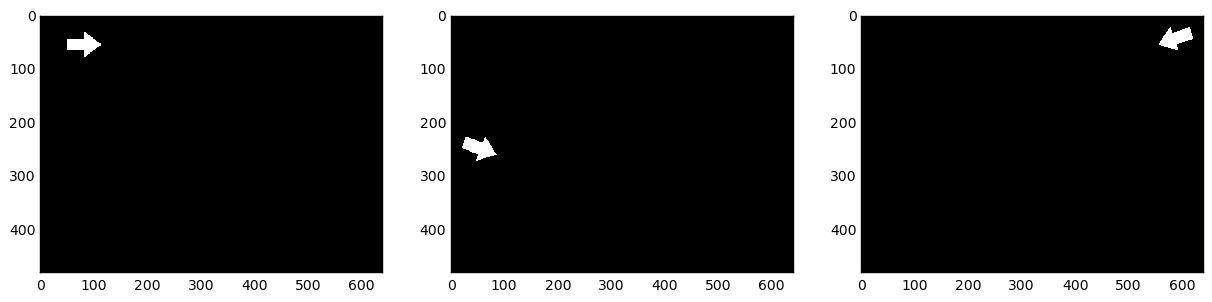

In [24]:
plt.figure(figsize=(15, 20))
plt.subplot(1, 3, 1)
io.imshow(get_start_arrow(real_imgs[0], all_labels[0])[1])
plt.subplot(1, 3, 2)
io.imshow(get_start_arrow(real_imgs[1], all_labels[1])[1])
plt.subplot(1, 3, 3)
io.imshow(get_start_arrow(real_imgs[2], all_labels[2])[1])

### Направление стрелки

In [30]:
def arrow_component(arrow, img_labeled):
    img_with_arrow = np.zeros((img_labeled.shape))
    for i in xrange(img_labeled.shape[0]):
        for j in xrange(img_labeled.shape[1]):
            if img_labeled[i][j] == arrow:
                img_with_arrow[i][j] = img_labeled[i][j]
    return img_with_arrow

In [70]:
def arrow_dot_pos(img, arrow, first_arrow=False):
    for i in xrange(img.shape[0]):
        for j in xrange(img.shape[1]):
            if arrow[i][j] > 0:
                # подобранные магические константы всегда возвращают центр кружочка
                if (first_arrow or img[i][j][0] < 50) and img[i][j][2] < 50 and img[i][j][1] > 200:
                    return i, j

In [38]:
def mass_center(arrow):
    dx = dy = n = 0
    for i in range(arrow.shape[0]):
        for j in range(arrow.shape[1]):
            if arrow[i][j]:
                dx += i
                dy += j
                n += 1
    return dx // n, dy // n

(480, 640)


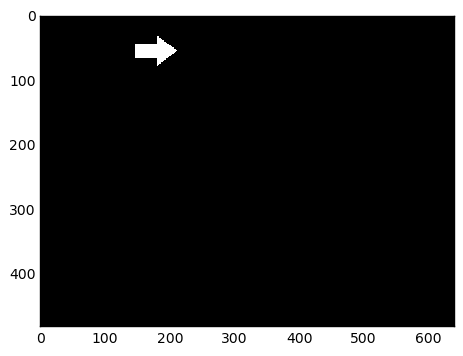

In [65]:
arrow_label = get_start_arrow(real_imgs[0], all_labels[0])[0]
arrow = arrow_component(arrow_label, all_labels[0])
x, y = arrow_dot_pos(real_imgs[0], arrow, first_arrow=True)
x1, y1 = mass_center(arrow)
dx, dy = x - x1, y - y1
while all_labels[0][int(x)][int(y)] == 0 or all_labels[0][int(x)][int(y)] == arrow_label:
    x += dx * 0.5
    y += dy * 0.5
next_arrow = arrow_component(all_labels[0][int(x)][int(y)], all_labels[0])
io.imshow(next_arrow)


### Поиск клада

In [68]:
def find_treasure(img):
    bin_img = binarize(img)
    labels = measure.label(bin_img)
    arrow_lables = get_arrows(labels)[0]
    first_label = get_start_arrow(img, labels)[0]
    first_arrow = arrow_component(first_label, labels)
    x, y = arrow_dot_pos(img, first_arrow, first_arrow=True)
    x1, y1 = mass_center(first_arrow)
    dx, dy = x - x1, y - y1
    while labels[int(x)][int(y)] == 0 or labels[int(x)][int(y)] == first_label:
        x += dx * 0.5
        y += dy * 0.5
    while labels[int(x)][int(y)] in arrow_lables:
        cur_label = labels[int(x)][int(y)]
        cur_arrow = arrow_component(cur_label, labels)
        x, y = arrow_dot_pos(img, cur_arrow, first_arrow=True)
        x1, y1 = mass_center(cur_arrow)
        dx, dy = x - x1, y - y1
        while labels[int(x)][int(y)] == 0 or labels[int(x)][int(y)] == cur_label:
            x += dx * 0.5
            y += dy * 0.5
    return arrow_component(labels[int(x)][int(y)], labels)

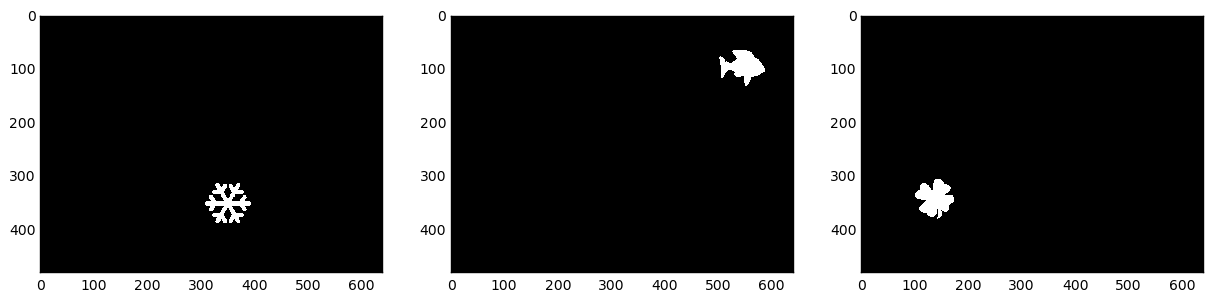

In [72]:
plt.figure(figsize=(15, 20))
plt.subplot(1, 3, 1)
io.imshow(find_treasure(real_imgs[0]))
plt.subplot(1, 3, 2)
io.imshow(find_treasure(real_imgs[1]))
plt.subplot(1, 3, 3)
io.imshow(find_treasure(real_imgs[2]))